# Preprocessing

In [78]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from scipy.interpolate import interp1d

In [79]:
codes_states = [('AK', 'Alaska'), ('AL', 'Alabama'), ('AZ', 'Arizona'), ('AR', 'Arkansas'), ('CA', 'California'), ('CO', 'Colorado'), ('CT', 'Connecticut'), ('DE', 'Delaware'), ('FL', 'Florida'), ('GA', 'Georgia'), ('HI', 'Hawaii'), ('ID', 'Idaho'), ('IL', 'Illinois'), ('IN', 'Indiana'), ('IA', 'Iowa'), ('KS', 'Kansas'), ('KY', 'Kentucky'), ('LA', 'Louisiana'), ('ME', 'Maine'), ('MD', 'Maryland'), ('MA', 'Massachusetts'), ('MI', 'Michigan'), ('MN', 'Minnesota'), ('MS', 'Mississippi'), ('MO', 'Missouri'), ('MT', 'Montana'), ('NE', 'Nebraska'), ('NV', 'Nevada'), ('NH', 'New Hampshire'), ('NJ', 'New Jersey'), ('NM', 'New Mexico'), ('NY', 'New York State'), ('NC', 'North Carolina'), ('ND', 'North Dakota'), ('OH', 'Ohio'), ('OK', 'Oklahoma'), ('OR', 'Oregon'), ('PA', 'Pennsylvania'), ('RI', 'Rhode Island'), ('SC', 'South Carolina'), ('SD', 'South Dakota'), ('TN', 'Tennessee'), ('TX', 'Texas'), ('UT', 'Utah'), ('VT', 'Vermont'), ('VA', 'Virginia'), ('WA', 'Washington'), ('WV', 'West Virginia'), ('WI', 'Wisconsin'), ('WY', 'Wyoming')]
codes = [a for a, _ in codes_states] + ['USA']
names = [b for _, b in codes_states] + ['USA']
to_name = dict(codes_states)
to_code = dict([(b, a) for a, b in codes_states])

In [80]:
# helpers

# Converts day to number
# Gets the number of days before (negative) or after (positive) 1/1/2021
def date_to_day(string):
    v1 = datetime.strptime(string, "%Y-%m-%d")
    v2 = date(v1.year, v1.month, v1.day)
    v3 = (v2 - date(v2.year, 1, 1)).days + 1
    if v2.year == 2020:
        v3 = v3 - 365
    return v3

# Convert a series of dates to days as per the above function
def dates_to_days(series):
    lst = series.to_numpy()
    days = [date_to_day(v) for v in lst]
    df = pd.DataFrame(data=days, columns=['day'])
    return df

# Fill in missing values for a series
def fill_missing(x, y):
    new_x, new_y = [], []
    for i in range(0, len(x)):

        if not new_y:
            if np.isnan(y[i]):
                continue
            # If no data at all that isn't NaN, return None
            if i == len(y):
                return None
            # At this point, it must be the case that all data encountered
            # in the for loop must be NaN except this value. Fill everything 
            # with this value
            for j in range(i+1):
                new_x.append(x[j])
                new_y.append(y[i])
            continue
        
        # If we have that days are skipped, we fill in with days
        # from the last unskipped day
        while new_x[-1] < x[i] - 1:
            new_x.append(new_x[-1] + 1)
            new_y.append(new_y[-1])
        new_x.append(x[i])
        # If the value for y is NaN, use the last valid value
        if np.isnan(y[i]):
            new_y.append(new_y[-1])
        else:
            new_y.append(y[i])

    return new_x, new_y

# Interpolate data
def interpolate(y):
    update_idxs = [0]
    for i in range(1, len(y)):
        if y[i] != y[update_idxs[-1]]:
            update_idxs.append(i)
    update_idxs[-1] = len(y) - 1
    f = interp1d(update_idxs, np.array(y)[update_idxs])
    new_y = list(f(list(range(len(y)))))
    return new_y

## Vaccinations

In [81]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
raw_df['day'] = dates_to_days(raw_df['date'])
df = raw_df[['day', 'location', 'people_fully_vaccinated_per_hundred', 'people_fully_vaccinated']]
df = df.rename(columns={'location' : 'loc', 'people_fully_vaccinated_per_hundred' : 'vacc_per_100'})

df_per_state = {}
for name in names:
    if name == 'USA':
        continue
    df_per_state[name] = df[df['loc'] == name][['day', 'vacc_per_100', 'people_fully_vaccinated']]
    df_per_state[name] = df_per_state[name].reset_index(drop=True)

# vacc_dct structure:
# vacc_dct takes a key of a US state postal code or just 'USA'
# Its value is a dictionary:
# 'day' -> List of days
# 'vacc' -> List of fully vaccininated people per 100 (interpolated) over time
# 'total' -> List of total people fully vaccinated over time (days)
vacc_dct = {}
for name, state_df in df_per_state.items():
    raw_days = state_df['day'].to_numpy()
    raw_vacc = state_df['vacc_per_100'].to_numpy()
    raw_total = state_df['people_fully_vaccinated'].to_numpy()
    
    val = fill_missing(raw_days, raw_vacc)
    if val is None:
        continue
    days, vacc = val
    interpolated = interpolate(vacc)
    
    val = fill_missing(raw_days, raw_total)
    if val is None:
        continue
    _, total = val

    vacc_dct[to_code[name]] = {'day' : days, 'vacc' : vacc, 'interp' : interpolated, 'total' : total}

# Calculate total fully vaccinated people and per 100 for USA
days = vacc_dct['AK']['day']
total = np.zeros(len(days))
for code in vacc_dct:
    total += vacc_dct[code]['total']
vacc = total / (328.2 * 1000000) * 100

vacc_dct['USA'] = {'day' : days, 'vacc' : vacc, 'interp' : vacc, 'total' : total}

## Variants

In [82]:
# Make sure the outbreak data is updated before using this
with open('outbreak_combined_us_state_data.json') as json_file:
    raw_dct = json.load(json_file)

with open('outbreak_us.json') as json_file:
    raw_dct += json.load(json_file)

# variants_dct structure:
# variants_dct takes a key of a variant type
# Its value is a dictionary that takes a US postal code or 'USA' as a key
# This dictionary then has the following:
# 'day' -> List of days
# 'prop' -> List of proportion for that variant over time (days)
# 'interp' -> Interpolated proportions
variants_dct = {}
for i in range(len(raw_dct)):
    if 'label' not in raw_dct[i]:
        continue
    if raw_dct[i]['label'] not in variants_dct:
        variants_dct[raw_dct[i]['label']] = {}
    days, prop = [], []
    for point in raw_dct[i]['data']:
        days.append(date_to_day(point['date']))
        prop.append(point['proportion'])
    if days:
        days, prop = fill_missing(days, prop)
        interpolated = interpolate(prop)
    # only want days after we have vaccination data
    if days and days[0] < 12:
        idx = days.index(12)
        days = days[idx:]
        prop = prop[idx:]
        interpolated = interpolated[idx:]
    dct = {'day' : days, 'prop' : prop, 'interp' : interpolated}
    name = raw_dct[i]['route']['selected'][7:]
    if name == '':
        name = raw_dct[i]['route']['selected']
    variants_dct[raw_dct[i]['label']][name] = dct

print(variants_dct['B.1.1.7']['AL'].keys())

dict_keys(['day', 'prop', 'interp'])


# Models

In [83]:
# Universal Model Parameters

# How much ahead we are predicting
days_ahead = 10
# How many days of data we are using to predict
lag_order = 14

# data from last ~two weeks has not been finalized
end_test = -14

# LSTM

## Time Series

In [84]:
# Amount of test points we're using per state
test_points_per_state = 3
end_test_input = end_test - days_ahead
end_train_input = end_test_input - lag_order - (test_points_per_state - 1)

# Minimum number of acceptable training points
# It is very small, but that is why we train a single model for all states
min_train_points_per_state = 5
min_start_train = end_train_input - (lag_order - 1) - (min_train_points_per_state - 1)

# Note that the training and testing points are entirely distinct in terms of
# the window they are using. This makes sure we aren't considering the test 
# set when training.
# In other words, the inputs to the testing points have no overlap with the inputs
# to the testing points.

# Convert data into the desired input for LSTM
def input_output(days, prop, vacc, code, first_start_idx, last_start_idx):
    state = [0 for _ in range(len(codes))]
    state[codes.index(code)] = 1
    x, y = [], []
    for i in range(first_start_idx, last_start_idx):
        x_point = []
        for j in range(i, i + lag_order):
            x_point.append(state + [days[j], vacc[j], prop[j]])
        x.append(x_point)
        y.append(prop[j + days_ahead])
    return x, y

# X train and test take the key of a variant 
# and then by postal code/'USA'/or 'all' to get relevant training/testing data

# Y similar structure but for output data instead
X_train, Y_train = {}, {}
X_test, Y_test = {}, {}

for variant in variants_dct: 
    
    X_train[variant], Y_train[variant] = {'all' : []}, {'all' : []}
    X_test[variant], Y_test[variant] = {'all' : []}, {'all' : []}
    
    for code in variants_dct[variant]:
        days = variants_dct[variant][code]['day']
        
        if not days or days[0] >= days[-1] + min_start_train:
            continue
        
        prop = variants_dct[variant][code]['interp']

        i1 = vacc_dct[code]['day'].index(days[0])

        # Variant data takes time to be updated on outbreak, so vacc 
        # is longer than prop most of the time. So don't be alarmed 
        # if you notice this to be the case.
        vacc = vacc_dct[code]['interp'][i1:]
        
        first_start_idx = 0
        last_start_idx = len(days) + end_train_input - lag_order
        x, y = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
        X_train[variant][code], Y_train[variant][code] = x, y
        X_train[variant]['all'] += x
        Y_train[variant]['all'] += y

        first_start_idx = len(days) + end_train_input
        last_start_idx = first_start_idx + 3
        x, y = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
        X_test[variant][code], Y_test[variant][code] = x, y
        X_test[variant]['all'] += x
        Y_test[variant]['all'] += y

## Train

In [85]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
import keras

models = {}

for variant in X_train:
    x, y = np.array(X_train[variant]['all']), np.array(Y_train[variant]['all'])
    print('Number of data points: {}'.format(len(x)))
    model = Sequential()
    # Added dropout here 
    model.add(LSTM(3, activation='relu', dropout=0.1, return_sequences=True, input_shape=(lag_order, 54)))
    model.add(LSTM(2, activation='relu', input_shape=(lag_order, 54)))
    model.add(Dense(1))
    model.summary()
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mse')
    model.fit(x, y, epochs=25, validation_split=0.1, verbose=1)
    models[variant] = model

Number of data points: 2736
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 14, 3)             696       
_________________________________________________________________
lstm_31 (LSTM)               (None, 2)                 48        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 747
Trainable params: 747
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
77/77 [==============================] - 6s 28ms/step - loss: 0.1082 - val_loss: 0.0240
Epoch 2/25
77/77 [==============================] - 1s 12ms/step - loss: 0.0453 - val_loss: 0.0126
Epoch 3/25
77/77 [==============================] - 1s 12ms/step - loss: 0.0248 - val_loss: 0.0154
Epoch 4/25
77/77 [==============================] - 1s 12ms/

## Evaluate

In [86]:
# If less than 70 data points, don't consider it
thresh = 70

# Keep track of scores based first on variant type and then mse/mae
scores = {}

for variant in models:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    n_states = 0
    for code in X_test[variant]:
        if code == 'all':
            continue
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        # Predict model
        pred = models[variant].predict(X_test[variant][code])
        # Get MAE and MSE
        scores[variant]['mae'] += sum([abs(pred[i][0] - Y_test[variant][code][i]) for i in range(test_points_per_state)])
        scores[variant]['mse'] += sum([(pred[i][0] - Y_test[variant][code][i]) ** 2 for i in range(test_points_per_state)])
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.08877404552936072, 'mse': 0.012248151415046564}, 'B.1.351': {'mae': 0.020898788273538166, 'mse': 0.0006090288022910419}, 'P.1': {'mae': 0.06168555462862089, 'mse': 0.010783604553411779}, 'B.1.427': {'mae': 0.014239605407296014, 'mse': 0.0003660637191474511}, 'B.1.429': {'mae': 0.07617744343187961, 'mse': 0.006658564070293566}}


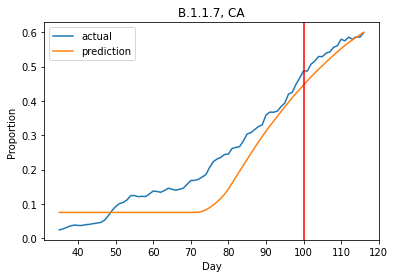

In [87]:
# Compares LSTM predicted variant proportion to actual results.
# Red line marks the first prediction that is not an interpolation
# (was outside of training set).

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

first_start_idx = 0
last_start_idx = len(days) + end_train_input + 3
input, actual = input_output(days, prop, vacc, code, first_start_idx, last_start_idx)
pred = models[variant].predict(input)

n = lag_order + days_ahead - 1
plt.plot([d for d in days[n:end_test]], actual, label='actual')
plt.plot([d for d in days[n:end_test]], pred, label='prediction')
plt.axvline(x=days[-1] + end_train_input + days_ahead, color='r')
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

# VAR

## Time Series

In [88]:
test_points_per_state = 3

# Splits the available points into a train and test set.
# The test set is large enough to include n test points
# which are predicted from inputs that are disjoint from
# the training set.
def train_test(code, variant, n=test_points_per_state):
    days = variants_dct[variant][code]['day']
    prop = variants_dct[variant][code]['interp']
    
    i1 = vacc_dct[code]['day'].index(days[0])
    vacc = vacc_dct[code]['interp'][i1:]
    vacc = vacc[:len(days)]

    i2 = end_test - days_ahead - n
    train = np.array([days[:i2], vacc[:i2], prop[:i2]]).T
    test = np.array([days[i2:end_test], vacc[i2:end_test], prop[i2:end_test]]).T

    return train, test

## Train

In [89]:
from statsmodels.tsa.api import VAR

# Return trained VAR model for a given state and variant.
# The lag order, denoted lag, is chosen to be the one
# estimated by the above package to be the best between 
# smallest and largest.
def trained_model(code, variant, n=test_points_per_state):
    train, _ = train_test(code, variant, n=n)
    model = VAR(train)
    smallest, largest = 5, 8
    lag_orders = list(range(smallest, largest + 1))
    aic_scores = [model.fit(i).aic for i in lag_orders]
    lag = np.argmin(aic_scores) + smallest
    model = model.fit(lag)
    return model

## Evaluate

In [90]:
# If less than 70 data points don't consider the state/variant
thresh = 70

scores = {}

for variant in variants_dct:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    n_states = 0
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        model = trained_model(code, variant)
        train, test = train_test(code, variant)
        pred = model.forecast(y=train, steps=days_ahead+test_points_per_state)
        scores[variant]['mae'] += sum([abs(pred[i][2] - test[i][2]) for i in range(days_ahead, days_ahead+test_points_per_state)])
        scores[variant]['mse'] += sum([(pred[i][2] - test[i][2]) ** 2 for i in range(days_ahead, days_ahead+test_points_per_state)])
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.14585040862624377, 'mse': 0.03128055082054928}, 'B.1.351': {'mae': 0.0072901588699159385, 'mse': 0.00010594387555624834}, 'P.1': {'mae': 0.02288192666304445, 'mse': 0.0008423947971425896}, 'B.1.427': {'mae': 0.03156486075830882, 'mse': 0.003338467498941643}, 'B.1.429': {'mae': 0.054720238084491356, 'mse': 0.007124290226700454}}


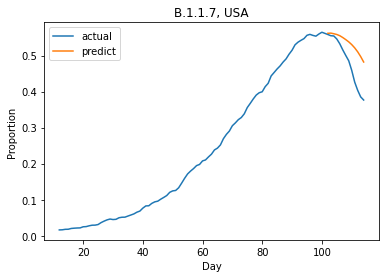

In [91]:
# Compares VAR predicted variant proportion to actual results.
# Predictions are only shown for points that are shifted by
# a full prediction window from the end of the training set.

variant, code = 'B.1.1.7', 'USA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

plt.plot(days[:end_test], prop[:end_test], label='actual')

model = trained_model(code, variant)
train, test = train_test(code, variant)
pred = model.forecast(y=train, steps=days_ahead+test_points_per_state)

plt.plot(test[:, 0], pred[:, 2], label='predict')

plt.legend()
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.show()

# Ensemble

Average predictions between the VAR and the LSTM

In [92]:
class Ensemble():
    
    def __init__(self, code, lstm, var):
        self.lstm = lstm
        self.var = var
        self.code = code

    def predict(self, days, vacc, prop):
        one_hot = [0 for _ in codes]
        one_hot[codes.index(self.code)] = 1
        lstm_input = []
        for i in range(lag_order):
            pt = one_hot + [days[-lag_order+i], vacc[-lag_order+i], prop[-lag_order+i]]
            lstm_input.append(pt)
        lstm_input = np.array([lstm_input])
        pred1 = self.lstm.predict(lstm_input)[0][0]

        var_input = np.array([days, vacc, prop]).T
        pred2 = self.var.forecast(y=var_input, steps=days_ahead)[-1][2]

        return (pred1 + pred2) / 2

## Evaluate

In [93]:
thresh = 70
test_points_per_state = 3

scores = {}

for variant in variants_dct:
    scores[variant] = {}
    scores[variant]['mae'] = 0
    scores[variant]['mse'] = 0
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state

        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            scores[variant]['mae'] += abs(pred - test)
            scores[variant]['mse'] += (pred - test) ** 2
    
    scores[variant]['mae'] /= test_points_per_state * n_states
    scores[variant]['mse'] /= test_points_per_state * n_states

print(scores)

{'B.1.1.7': {'mae': 0.08489659033295048, 'mse': 0.011257995672478732}, 'B.1.351': {'mae': 0.01105736351369733, 'mse': 0.0001686122385440345}, 'P.1': {'mae': 0.035168541344107004, 'mse': 0.0036429431239764524}, 'B.1.427': {'mae': 0.017625321494274298, 'mse': 0.0009058979668008744}, 'B.1.429': {'mae': 0.04327422946987523, 'mse': 0.0026632410312667624}}


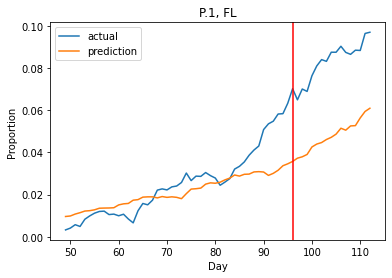

In [94]:
variant, code = 'P.1', 'FL'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in days[n:end_test]], prop[n:end_test], label='actual')
plt.plot([d for d in days[n:end_test]], pred, label='prediction')
plt.axvline(x=days[-1] + end_train_input + days_ahead, color='r')
plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

# Interpretation

## Cross-Correlation

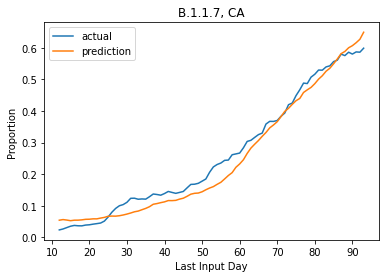

In [95]:
# input days vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in days[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in days[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

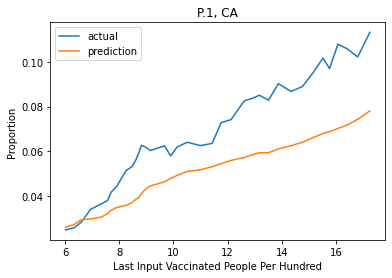

In [178]:
# input vacc vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in vacc[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in vacc[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Vaccinated People Per Hundred')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

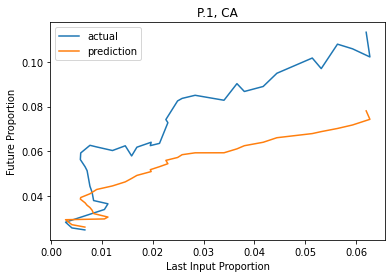

In [179]:
# input prop vs prop

variant, code = 'B.1.1.7', 'CA'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in prop[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in prop[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Proportion')
plt.ylabel('Future Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

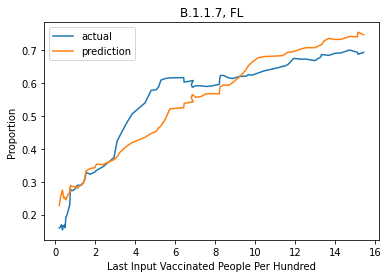

In [96]:
# input vacc vs prop

variant, code = 'B.1.1.7', 'FL'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in vacc[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in vacc[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Vaccinated People Per Hundred')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

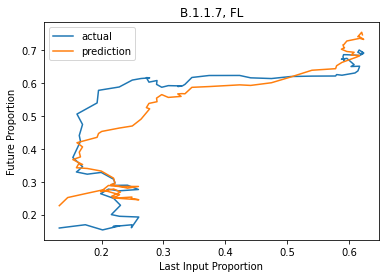

In [97]:
# input prop vs predicted prop

variant, code = 'B.1.1.7', 'FL'
days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = vacc[:len(days)]

ensemble = Ensemble(code, models[variant], trained_model(code, variant))
n = lag_order + days_ahead - 1

input = []
for i in range(len(days) + end_test - n):
    i_days = days[i:i+lag_order]
    i_vacc = vacc[i:i+lag_order]
    i_prop = prop[i:i+lag_order]
    input.append((i_days, i_vacc, i_prop))

pred = [ensemble.predict(d, v, p) for d, v, p in input]    

plt.plot([d for d in prop[:end_test-n]], prop[n:end_test], label='actual')
plt.plot([d for d in prop[:end_test-n]], pred, label='prediction')
plt.xlabel('Last Input Proportion')
plt.ylabel('Future Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

## Variable Importance

In [98]:
importances = {}

thresh = 70

for variant in variants_dct:
    importances[variant] = {}
    start, end = 70, 70 + lag_order
    
    # average inputs for days, variant proportions, and vaccination rates
    base_days = np.arange(start, end)
    base_prop = np.zeros(lag_order)
    base_vacc = np.zeros(lag_order)

    count = 0
    for code in variants_dct[variant]:
        days = variants_dct[variant][code]['day']
        if start in days and end in days:
            count += 1
            
            idx = days.index(start)
            prop = variants_dct[variant][code]['interp'][idx:idx + lag_order]
            base_prop += prop

            vacc = vacc_dct[code]['interp'][idx:idx + lag_order]
            base_vacc += vacc

    base_prop /= count
    base_vacc /= count

    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue

        importances[variant][code] = {}

        ensemble = Ensemble(code, models[variant], trained_model(code, variant))
        base_pred = ensemble.predict(base_days, base_vacc, base_prop)

        # perturbing input days and evaluating the effect on predictions
        # two metrics - mean absolute difference and mean squared distance
        mad_dif, msd_dif = 0, 0

        start, end = -5, 6
        for i in range(start, end):
            new_days = base_days + i
            new_pred = ensemble.predict(new_days, base_vacc, base_prop)
            mad_dif += abs(new_pred - base_pred)
            msd_dif += (new_pred - base_pred) ** 2
        
        mad_dif /= end - start
        msd_dif /= end - start

        importances[variant][code]['day'] = {}
        importances[variant][code]['day']['mad'] = mad_dif
        importances[variant][code]['day']['msd'] = msd_dif

        # perturbing input vaccination rates and evaluating the effect on predictions
        # two metrics - mean absolute difference and mean squared distance
        mad_dif, msd_dif = 0, 0

        start, end = -5, 6
        for i in range(start, end):
            new_vacc = base_vacc + i
            new_pred = ensemble.predict(base_days, new_vacc, base_prop)
            mad_dif += abs(new_pred - base_pred)
            msd_dif += (new_pred - base_pred) ** 2
        
        mad_dif /= end - start
        msd_dif /= end - start

        importances[variant][code]['vacc'] = {}
        importances[variant][code]['vacc']['mad'] = mad_dif
        importances[variant][code]['vacc']['msd'] = msd_dif

        # perturbing input variant proportion and evaluating the effect on predictions
        # two metrics - mean absolute difference and mean squared distance
        mad_dif, msd_dif = 0, 0

        start, end = -5, 6
        for i in range(start, end):
            new_prop = base_prop + i / 100
            new_pred = ensemble.predict(base_days, base_vacc, new_prop)
            mad_dif += abs(new_pred - base_pred)
            msd_dif += (new_pred - base_pred) ** 2
        
        mad_dif /= end - start
        msd_dif /= end - start

        importances[variant][code]['prop'] = {}
        importances[variant][code]['prop']['mad'] = mad_dif
        importances[variant][code]['prop']['msd'] = msd_dif

# averages model sensitivity to variations of each feature over all states
avg_importances = {}
for variant in importances:
    avg_importances[variant] = {}
    for code in importances[variant]:
        for feature in importances[variant][code]:
            avg_importances[variant][feature] = {} 
            avg_importances[variant][feature]['mad'] = 0
            avg_importances[variant][feature]['msd'] = 0
        for feature in importances[variant][code]:
            avg_importances[variant][feature]['mad'] += importances[variant][code][feature]['mad']
            avg_importances[variant][feature]['msd'] += importances[variant][code][feature]['msd']
    for feature in importances[variant][code]:
        avg_importances[variant][feature]['mad'] /= len(importances[variant])
        avg_importances[variant][feature]['msd'] /= len(importances[variant])

summary = {}
for feature in avg_importances[variant]:
    summary[feature] = {}
    summary[feature]['mad'] = 0
    summary[feature]['msd'] = 0
    for variant in avg_importances:
        summary[feature]['mad'] += avg_importances[variant][feature]['mad']
        summary[feature]['msd'] += avg_importances[variant][feature]['msd']
    summary[feature]['mad'] /= len(avg_importances)
    summary[feature]['msd'] /= len(avg_importances)

print(avg_importances)

print(summary)

{'B.1.1.7': {'day': {'mad': 0.00042272478596064474, 'msd': 1.0865302583411728e-05}, 'vacc': {'mad': 0.0006704803687566879, 'msd': 3.0173015502799325e-05}, 'prop': {'mad': 0.00035180933954079437, 'msd': 7.488118876178271e-06}}, 'B.1.351': {'day': {'mad': 6.988516416052144e-05, 'msd': 1.2927231624778316e-07}, 'vacc': {'mad': 0.00023288477809291114, 'msd': 1.857752608676007e-06}, 'prop': {'mad': 0.00022395940672110246, 'msd': 1.281255459502149e-06}}, 'P.1': {'day': {'mad': 2.234061498610155e-05, 'msd': 6.7101636036470065e-09}, 'vacc': {'mad': 0.00035839742188898625, 'msd': 1.7269215726685881e-06}, 'prop': {'mad': 0.0008594827536848842, 'msd': 9.931553674410207e-06}}, 'B.1.427': {'day': {'mad': 5.015339018336849e-05, 'msd': 1.6570649489424954e-07}, 'vacc': {'mad': 0.0003049587293998917, 'msd': 6.126621912577109e-06}, 'prop': {'mad': 0.00014471774832122382, 'msd': 1.3796932331196587e-06}}, 'B.1.429': {'day': {'mad': 8.373645510840642e-05, 'msd': 4.6192140129812325e-07}, 'vacc': {'mad': 0.00

In [99]:
# Compares the effect of perturbing input vaccination rate
# to the effect of perturbing the input variant proportion.
# i.e. measuring to what extent the model is learning
#      the effect of vaccination vs just propogating the
#      past variant proportion in some vaccination-independent
#      way

mad_vacc, mad_prop = 0, 0
msd_vacc, msd_prop = 0, 0

for variant in avg_importances:
    mad_vacc += avg_importances[variant]['vacc']['mad']
    mad_prop += avg_importances[variant]['prop']['mad']
    msd_vacc += avg_importances[variant]['vacc']['msd']
    msd_prop += avg_importances[variant]['prop']['msd']

mad_ratio = mad_vacc / mad_prop
msd_ratio = msd_vacc / msd_prop

print('MAD for tweaking vaccination / MAD for tweaking variant prop : {}'.format(mad_ratio))
print('MSD for tweaking vaccination / MSD for tweaking variant prop : {}'.format(msd_ratio))

if mad_ratio > 1:
    print('Model predictions may depend more on vaccination rates than past variant proportions.')
else:
    print('Model predictions may depend more on past variant proportions than vaccination rates.')

MAD for tweaking vaccination / MAD for tweaking variant prop : 1.282178650204942
MSD for tweaking vaccination / MSD for tweaking variant prop : 2.7669804592204468
Model predictions may depend more on vaccination rates than past variant proportions.


## Vaccination Effect on Variant Proportion

In [100]:
# For each variant and state, we scale the vaccination rate to three different
# levels and compute the average predicted variant proportion at each level of
# vaccination. This gives us a sense of the effects of different levels of 
# vaccination on variant proportions for each variant as learned by the models.

thresh = 70

# Predictions using the ensemble are computationally expensive.
# To reduce the runtime of this cell, we cap the number of predictions
# made per state to 20.
max_preds_per_state = 20

# scaling factors for designation of vaccination rates
# as low, medium, or high
low_scale = 0.5
med_scale = 1
high_scale = 1.5

mean_variant_prop = {}

for variant in variants_dct:
    mean_variant_prop[variant] = {}
    
    mean_variant_prop[variant]['low'] = 0
    mean_variant_prop[variant]['med'] = 0
    mean_variant_prop[variant]['high'] = 0

    count = 0

    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue

        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        start, end = 0, len(days) + end_test - lag_order
        start = max(start, end - max_preds_per_state)
        for i in range(start, end):
            count += 1

            input_days = days[i : i + lag_order]
            input_vacc = np.array(vacc[i : i + lag_order])
            input_prop = prop[i : i + lag_order]

            low_vacc = low_scale * input_vacc
            med_vacc = med_scale * input_vacc
            high_vacc = high_scale * input_vacc

            mean_variant_prop[variant]['low'] += ensemble.predict(input_days, low_vacc, input_prop)
            mean_variant_prop[variant]['med'] += ensemble.predict(input_days, med_vacc, input_prop)
            mean_variant_prop[variant]['high'] += ensemble.predict(input_days, high_vacc, input_prop)

    mean_variant_prop[variant]['low'] /= count
    mean_variant_prop[variant]['med'] /= count
    mean_variant_prop[variant]['high'] /= count

print(mean_variant_prop)

{'B.1.1.7': {'low': 0.5806280693103415, 'med': 0.6702396894004146, 'high': 0.7644096995134684}, 'B.1.351': {'low': 0.022218654000508705, 'med': 0.020828982806533183, 'high': 0.028522419329304667}, 'P.1': {'low': 0.041470747051737096, 'med': 0.04360561669033129, 'high': 0.045740486328925425}, 'B.1.427': {'low': 0.05937908786717627, 'med': 0.019998845979310845, 'high': -0.02112684005322804}, 'B.1.429': {'low': 0.15377116775310323, 'med': 0.062423237316486815, 'high': -0.028924693120129696}}


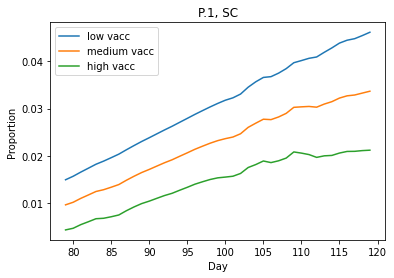

In [103]:
code, variant = 'SC', 'P.1'

ensemble = Ensemble(code, models[variant], trained_model(code, variant))

days = variants_dct[variant][code]['day']
prop = variants_dct[variant][code]['interp']
i1 = vacc_dct[code]['day'].index(days[0])
vacc = vacc_dct[code]['interp'][i1:]
vacc = np.array(vacc[:len(days)])

pred_days = []
pred_low = []
pred_med = []
pred_high = []

start, end = 0, len(days) + end_test - lag_order
for i in range(start, end):
    input_days = days[i : i + lag_order]
    input_vacc = vacc[i : i + lag_order]
    input_prop = prop[i : i + lag_order]

    pred_days.append(days[i + lag_order + days_ahead])

    low_vacc = low_scale * input_vacc
    med_vacc = med_scale * input_vacc
    high_vacc = high_scale * input_vacc

    pred_low.append(ensemble.predict(input_days, low_vacc, input_prop))
    pred_med.append(ensemble.predict(input_days, med_vacc, input_prop))
    pred_high.append(ensemble.predict(input_days, high_vacc, input_prop))

plt.plot(pred_days, pred_low, label='low vacc')
plt.plot(pred_days, pred_med, label='medium vacc')
plt.plot(pred_days, pred_high, label='high vacc')

plt.xlabel('Day')
plt.ylabel('Proportion')
plt.title('{}, {}'.format(variant, code))
plt.legend()
plt.show()

## Actual vs. Predicted Correlation

In [64]:
thresh = 50
test_points_per_state = 3

import collections
actual = collections.defaultdict(list)
predicted = collections.defaultdict(list)

for variant in variants_dct:
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state

        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            actual[variant].append(test)
            predicted[variant].append(pred)

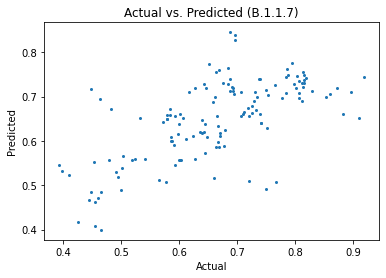

0.4375230142194011


In [65]:
code = 'B.1.1.7'
act = actual[code]
pre = predicted[code]

act_std = np.std(act)
pre_std = np.std(pre)

act_l = np.mean(act) - 2 * act_std
act_h = np.mean(act) + 2 * act_std

pre_l = np.mean(pre) - 2 * pre_std
pre_h = np.mean(pre) + 2 * pre_std

drop_act = []
drop_pre = []

for i in range(len(act)):
  if act_l <= act[i] <= act_h and pre_l <= pre[i] <= pre_h:
    drop_act.append(act[i])
    drop_pre.append(pre[i])

plt.scatter(drop_act, drop_pre, s=4)
plt.title("Actual vs. Predicted (" + code + ")")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

correlation_matrix = np.corrcoef(drop_act, drop_pre)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

## Look at Errors

In [128]:
thresh = 60
test_points_per_state = 3

import collections
mae_errors = collections.defaultdict(dict)
mse_errors = collections.defaultdict(dict)


for variant in variants_dct:
    
    n_states = 0 
    for code in variants_dct[variant]:
        N_pts = len(variants_dct[variant][code]['day']) + end_test
        if N_pts < thresh:
            continue
        n_states += 1
        ensemble = Ensemble(code, models[variant], trained_model(code, variant))

        train, test = train_test(code, variant, n=test_points_per_state)
        
        days = variants_dct[variant][code]['day']
        prop = variants_dct[variant][code]['interp']
        i1 = vacc_dct[code]['day'].index(days[0])
        vacc = vacc_dct[code]['interp'][i1:]
        vacc = vacc[:len(days)]

        first_end_idx = end_test - days_ahead - test_points_per_state
        MAE = 0
        MSE = 0
        for i in range(test_points_per_state):
            i_days, i_prop, i_vacc = days[:first_end_idx+i], prop[:first_end_idx+i], vacc[:first_end_idx+i]
            pred = ensemble.predict(i_days, i_vacc, i_prop)
            test = prop[first_end_idx+i+days_ahead]
            MAE += abs(pred - test)
            MSE += (pred - test) ** 2
        mae_errors[variant][code] = MAE / test_points_per_state
        mse_errors[variant][code] = MSE / test_points_per_state


In [123]:
# Gives a general ratio to help contextualize MAE
code = 'B.1.1.7'
maes = [(k, mae_errors[code][k]) for k in mae_errors[code]]
rem = []
for i in maes:
    if i[0] == 'USA':
        continue
    else:
        rem.append(i)
print(rem)

[('AL', 0.050251917493593035), ('AK', 0.01783171131675802), ('AZ', 0.03714007637003188), ('CA', 0.009790174011117037), ('CO', 0.19075658980274754), ('CT', 0.03254038254464664), ('DE', 0.06389902380209896), ('FL', 0.14302776981533316), ('GA', 0.02959173180178598), ('HI', 0.11628933402282038), ('ID', 0.1719229237454267), ('IL', 0.09695274357620191), ('IN', 0.008407428033759231), ('IA', 0.07285350288055843), ('KS', 0.18793636288288332), ('KY', 0.04159334285578268), ('LA', 0.0830452785092735), ('ME', 0.05899525118772538), ('MD', 0.11713660325752999), ('MA', 0.11578859426248889), ('MI', 0.10818642392196558), ('MN', 0.10172373660061929), ('MO', 0.05556649671672098), ('MT', 0.03487982659166564), ('NE', 0.0945260165769694), ('NV', 0.024412864384465327), ('NH', 0.019106327216075174), ('NJ', 0.07070024613856213), ('NM', 0.19469689325375908), ('NY', 0.0768387604892362), ('NC', 0.09854787339000852), ('ND', 0.09788321978046928), ('OH', 0.2570929716857469), ('OK', 0.0960575141090075), ('OR', 0.01890

In [124]:
import plotly.express as px

df = pd.DataFrame.from_dict(rem)
df = df.rename(columns={0: "State", 1: "MAE"})

fig = px.choropleth(df, locations="State", locationmode="USA-states", scope='usa',
                    color="MAE",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = code)
fig.show()

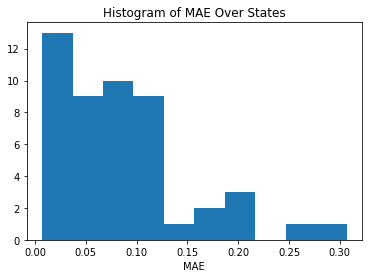

In [139]:
maes = [mae_errors['B.1.1.7'][k] for k in mae_errors['B.1.1.7']]

plt.hist(maes)
plt.xlabel("MAE")
plt.title("Histogram of MAE Over States")
plt.show()

Make sure gisaid_monthly_submit.csv is uploaded

In [153]:
df = pd.read_csv('gisaid_monthly_submit.csv')
df["State"] = df["Unnamed: 0"]

code = 'B.1.1.7'

total_reports = []
report_d = {}
for index, row in df.iterrows():
    if row['State'] not in to_code and row['State'] != "New York":
        continue
    elif row['State'] == "New York":
        state = 'NY'
    else:
        state = to_code[row['State']]
    total = row['country_total']
    total_reports.append((state, total / 1000))
    report_d[state] = total / 1000

df = pd.DataFrame.from_dict(total_reports)
df = df.rename(columns={0: "State", 1: "Reports"})

fig = px.choropleth(df, locations="State", locationmode="USA-states", scope='usa',
                    color="Reports",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title = code)
fig.show()


In [173]:
high = []
low = []

for state, error in rem:
    if error >= 0.08:
        high.append(report_d[state])
    else:
        low.append(report_d[state])
print(high)
print(low)

print(np.mean(high))
print(np.mean(low))

[10.389, 29.863, 2.191, 1.114, 15.809, 2.813, 4.906, 11.435, 17.015, 25.213, 20.2, 1.855, 4.887, 8.849, 1.439, 7.336, 0.669, 13.623, 3.275, 0.555, 8.446, 8.554, 13.605, 7.24]
[2.665, 1.739, 16.395, 56.269, 7.086, 1.76, 6.892, 5.704, 0.905, 1.809, 3.374, 2.94, 0.686, 3.847, 1.93, 12.417, 41.297, 7.152, 2.749, 3.874, 56.415, 0.985, 21.598, 4.772]
9.220041666666665
11.0525
